In [267]:
import torch_geometric.transforms as T
import os.path as osp
from sklearn.manifold import TSNE
import torch
import umap

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from embedding_functions import *
from experiment_setup import *
from functions_for_bootstrap import *
import numba as nb
from scipy.stats import wasserstein_distance
from tqdm import tqdm
import random
from scipy.integrate import simps
from matplotlib import cm
from matplotlib.patches import Ellipse
import seaborn as sns
from scipy.spatial.distance import cdist
from numpy.linalg import LinAlgError
import re

from sklearn.preprocessing import StandardScaler
from sklearn.covariance import LedoitWolf  # Import Ledoit-Wolf estimator
from sklearn.covariance import shrunk_covariance, EmpiricalCovariance
from matplotlib.lines import Line2D

Read in data

In [268]:
window = 60 * 60

day_1_start = (8 * 60 + 30) * 60
day_1_end = (17 * 60 + 30) * 60
day_2_start = ((24 + 8) * 60 + 30) * 60
day_2_end = ((24 + 17) * 60 + 30) * 60

T1 = int((day_1_end - day_1_start) // window)
T2 = int((day_2_end - day_2_start) // window)
T = T1 + T2

print(f"Number of time windows: {T}")

# %%
fname = "ia-primary-school-proximity-attr.edges"
file = open(fname)

label_dict = {
    "1A": 0,
    "1B": 1,
    "2A": 2,
    "2B": 3,
    "3A": 4,
    "3B": 5,
    "4A": 6,
    "4B": 7,
    "5A": 8,
    "5B": 9,
    "Teachers": 10,
}
num_classes = 10

nodes = []
node_labels = []
edge_tuples = []

for line in file:
    node_i, node_j, time, id_i, id_j = line.strip("\n").split(",")

    if day_1_start <= int(time) < day_1_end:
        t = (int(time) - day_1_start) // window
    elif day_2_start <= int(time) < day_2_end:
        t = T1 + (int(time) - day_2_start) // window
    else:
        continue

    if node_i not in nodes:
        nodes.append(node_i)
        node_labels.append(label_dict[id_i])

    if node_j not in nodes:
        nodes.append(node_j)
        node_labels.append(label_dict[id_j])

    edge_tuples.append([t, node_i, node_j])

edge_tuples = np.unique(edge_tuples, axis=0)
nodes = np.array(nodes)

n = len(nodes)
print(f"Number of nodes: {n}")

node_dict = dict(zip(nodes[np.argsort(node_labels)], range(n)))
node_labels = np.sort(node_labels)

# %% [markdown]
# Create a list of adjacency matrices.

# %%
As = np.zeros((T, n, n))

for m in range(len(edge_tuples)):
    t, i, j = edge_tuples[m]
    As[int(t), node_dict[i], node_dict[j]] = 1
    As[int(t), node_dict[j], node_dict[i]] = 1

Number of time windows: 18
Number of nodes: 242


In [269]:
# Format the data to work with existing code
labels = node_labels

# just look at first (whatever is specified) timepoint
dense_adj = As[1]

Define functions for notebook

In [270]:
def compute_area_above_below_curve(x, y):
    area_above = 0.0
    area_below = 0.0
    
    for i in range(1, len(x)):
        x0, x1 = x[i - 1], x[i]
        y0, y1 = y[i - 1], y[i]
        line0, line1 = x0, x1  # Since line y = x
        
        if y1 == y0:  # Vertical segment
            if y0 > x0:
                area_above += (y0 - x0) * (x1 - x0)
            else:
                area_below += (x0 - y0) * (x1 - x0)
            continue
        
        # Find intersection with y = x
        if (y0 >= x0 and y1 >= x1) or (y0 <= x0 and y1 <= x1):
            if y0 >= x0 and y1 >= x1:
                area_above += 0.5 * (y0 + y1 - x0 - x1) * (x1 - x0)
            else:
                area_below += 0.5 * (x0 + x1 - y0 - y1) * (x1 - x0)
        else:
            x_intersect = x0 + (x0 - y0) * (x1 - x0) / (y1 - y0)
            if y0 < x0:
                area_below += 0.5 * (x0 - y0) * (x_intersect - x0)
                area_above += 0.5 * (y1 - x1) * (x1 - x_intersect)
            else:
                area_above += 0.5 * (y0 - x0) * (x_intersect - x0)
                area_below += 0.5 * (x1 - y1) * (x1 - x_intersect)
    
    return area_above, area_below



def plot_ellipse(ax, mean, cov, color, lw=2):
    eigenvalues, eigenvectors = np.linalg.eigh(cov)
    order = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[order]
    eigenvectors = eigenvectors[:, order]
    angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))
    width, height = 2 * np.sqrt(eigenvalues[:2])
    ellipse = Ellipse(xy=mean, width=width, height=height, angle=angle, edgecolor=color, facecolor='none', lw=lw, label=f'Covariance Ellipse ({color})')
    ax.add_patch(ellipse)



# TO AVOID SINGULAR MATRIX ERROR
def points_within_ellipse(points, mean, cov, regularization=1e-32, threshold=3):
    try:
        # Attempt to calculate the inverse of the covariance matrix
        inv_cov = np.linalg.inv(cov)
    except LinAlgError:
        # If the matrix is singular, regularize and retry
        cov += np.eye(cov.shape[0]) * regularization
        inv_cov = np.linalg.inv(cov)
    
    # Calculate the Mahalanobis distance from the mean
    diff = points - mean
    mahalanobis_distances = np.sum(diff @ inv_cov * diff, axis=1)
    
    # Points within the ellipse have a Mahalanobis distance <= threshold
    return mahalanobis_distances <= threshold


#### Define functions for notebook

In [340]:
def compute_area_above_below_curve(x, y):
    area_above = 0.0
    area_below = 0.0
    
    for i in range(1, len(x)):
        x0, x1 = x[i - 1], x[i]
        y0, y1 = y[i - 1], y[i]
        line0, line1 = x0, x1  # Since line y = x
        
        if y1 == y0:  # Vertical segment
            if y0 > x0:
                area_above += (y0 - x0) * (x1 - x0)
            else:
                area_below += (x0 - y0) * (x1 - x0)
            continue
        
        # Find intersection with y = x
        if (y0 >= x0 and y1 >= x1) or (y0 <= x0 and y1 <= x1):
            if y0 >= x0 and y1 >= x1:
                area_above += 0.5 * (y0 + y1 - x0 - x1) * (x1 - x0)
            else:
                area_below += 0.5 * (x0 + x1 - y0 - y1) * (x1 - x0)
        else:
            x_intersect = x0 + (x0 - y0) * (x1 - x0) / (y1 - y0)
            if y0 < x0:
                area_below += 0.5 * (x0 - y0) * (x_intersect - x0)
                area_above += 0.5 * (y1 - x1) * (x1 - x_intersect)
            else:
                area_above += 0.5 * (y0 - x0) * (x_intersect - x0)
                area_below += 0.5 * (x1 - y1) * (x1 - x_intersect)
    
    return area_above, area_below


# def plot_ellipse(ax, mean, cov, color):
#     eigenvalues, eigenvectors = np.linalg.eigh(cov)
#     order = eigenvalues.argsort()[::-1]
#     eigenvalues = eigenvalues[order]
#     eigenvectors = eigenvectors[:, order]
#     angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))
#     width, height = 2 * np.sqrt(eigenvalues[:2])
#     ellipse = Ellipse(mean, width, height, angle, edgecolor=color, facecolor='none', lw=2, label=f'Covariance Ellipse ({color})')
#     ax.add_patch(ellipse)


def plot_ellipse(ax, mean, cov, color, lw=2):
    eigenvalues, eigenvectors = np.linalg.eigh(cov)
    order = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[order]
    eigenvectors = eigenvectors[:, order]
    angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))
    width, height = 2 * np.sqrt(eigenvalues[:2])
    ellipse = Ellipse(xy=mean, width=width, height=height, angle=angle, edgecolor=color, facecolor='none', lw=lw, label=f'Covariance Ellipse ({color})')
    ax.add_patch(ellipse)




# TO AVOID SINGULAR MATRIX ERROR
def points_within_ellipse(points, mean, cov, regularization=1e-32, threshold=3):
    try:
        # Attempt to calculate the inverse of the covariance matrix
        inv_cov = np.linalg.inv(cov)
    except LinAlgError:
        # If the matrix is singular, regularize and retry
        cov += np.eye(cov.shape[0]) * regularization
        inv_cov = np.linalg.inv(cov)
    
    # Calculate the Mahalanobis distance from the mean
    diff = points - mean
    mahalanobis_distances = np.sum(diff @ inv_cov * diff, axis=1)
    
    # Points within the ellipse have a Mahalanobis distance <= threshold
    return mahalanobis_distances <= threshold


In [272]:
k = 3
B = 30
d = 12

## Standardise so plots are mean 0, sd 1

In [273]:
# obs_adj is the observed adjacency matrix
# for each of the true draws from the model, create a bootstrap and perform a test with Q permutations
random.seed(100)
np.random.seed(100)

p_vals = []
A_boots_list = []

for b in tqdm(range(B)):
    p_val, A_boots = create_single_kNN_bootstrap(dense_adj, d=d, Q=1000, n_neighbors=k)
    p_vals.append(p_val)
    A_boots_list.append(A_boots)

print(f"B={B}, d={d}, k={k}")


100%|██████████| 30/30 [00:02<00:00, 14.99it/s]

B=30, d=12, k=3


In [274]:
A_list = [dense_adj] + A_boots_list
len(A_list)

yhat = UASE(A_list, d=d, sparse_matrix=False)

In [275]:
yadf = pd.DataFrame(yhat)

# rename the columns - this is called a list comprehension
yadf.columns = ["Dimension_{}".format(i+1) for i in range(yadf.shape[1])] 

# repeats tau list the len of A_true_boots_list times
yadf["tau"] = np.tile(node_labels, B + 1)

# add column for the matrix it is
yadf["Matrix"] = np.repeat(range(B+1), len(labels))

# repeat range(len(node_labels)) B+1 times to give each node a unique number
yadf['NodeNumber'] = list(range(len(node_labels)))*(B+1)

### B=20 and perplexity=30 make plots

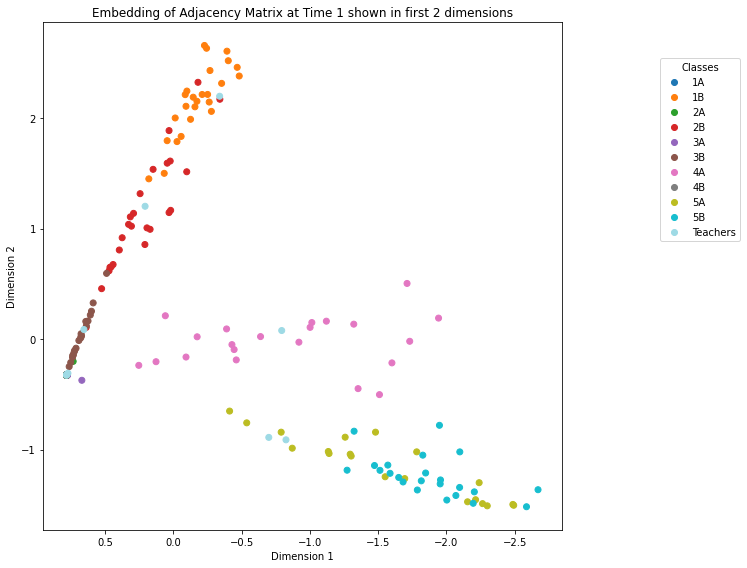

In [357]:
# Create a figure and axis object
fig, ax = plt.subplots(figsize=(8,8))

yhat_A = UASE([dense_adj], d=d, sparse_matrix=False)
yadf_A = pd.DataFrame(yhat_A)

# rename the columns - this is called a list comprehension
yadf_A.columns = ["Dimension_{}".format(i+1) for i in range(yadf_A.shape[1])] 

# repeats tau list the len of A_true_boots_list times
yadf_A["tau"] = np.tile(node_labels, 1)

# repeat range(len(node_labels)) B+1 times to give each node a unique number
yadf_A['NodeNumber'] = list(range(len(node_labels)))

# Aobs_yadf = yadf[yadf["Matrix"] == 0]

# Standardize the data in the Dimension_1 and Dimension_2 columns - so Dimension_1 and Dimension_2 have mean 0 and standard deviation 1
scaler = StandardScaler()
# Fit the scaler on the Dimension columns and transform them
# Aobs_yadf[["Dimension_1", "Dimension_2"]] = scaler.fit_transform(Aobs_yadf[["Dimension_1", "Dimension_2"]])
yadf_A[["Dimension_1", "Dimension_2"]] = scaler.fit_transform(yadf_A[["Dimension_1", "Dimension_2"]])

# Plot the scatter plot
# scatter = ax.scatter(Aobs_yadf["Dimension_1"], Aobs_yadf["Dimension_2"], c=Aobs_yadf["tau"], cmap='tab20')
scatter = ax.scatter(yadf_A["Dimension_1"], yadf_A["Dimension_2"], c=yadf_A["tau"], cmap='tab20')

ax.set_xlabel("Dimension 1")
ax.set_ylabel("Dimension 2")

# Set the title
ax.set_title(f"Embedding of Adjacency Matrix at Time 1 shown in first 2 dimensions")  

# Invert the x-axis
ax.invert_xaxis()

# Add legend for classes, mapping the integer labels back to the label_dict keys
handles, labels_legend = scatter.legend_elements()
label_dict_inv = {v: k for k, v in label_dict.items()}  # Inverse mapping
mapped_labels = []
for label in labels_legend:
    match = re.search(r'\d+', label)
    if match:
        numeric_label = int(match.group(0))
        mapped_labels.append(label_dict_inv.get(numeric_label, "Unknown"))

# Add the legend with the mapped labels
fig.legend(handles, mapped_labels, title="Classes", loc="upper right", bbox_to_anchor=(1.3, 0.9))

# Adjust layout to make room for titles and labels
plt.tight_layout()

# plt.savefig("figs/school_A1_embed_A_sd1mean0.png", bbox_inches='tight', facecolor='white')

# Show the combined plot
plt.show()

Plot A[1] adjacency matrix

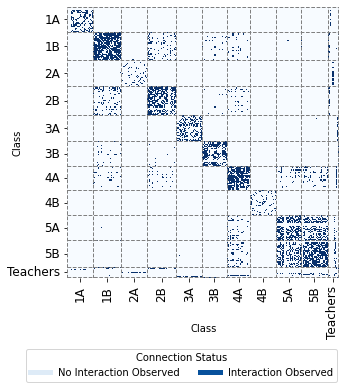

In [277]:
# Replace labels using label_dict_inv
mapped_labels = [label_dict_inv[label] for label in labels]

# Initialize a list to store the positions where the value changes
change_positions = [0]

# Loop through the list and find where the value changes
for i in range(1, len(mapped_labels)):
    if mapped_labels[i] != mapped_labels[i-1]:
        change_positions.append(i)  # Store the position of the change

# add on the last place for a change position - so that the teachers will get a label
change_positions.append(len(labels)-1)

# Get the corresponding labels for those positions
change_labels = [mapped_labels[i] for i in change_positions]

# Get the corresponding labels for the middle of each section
middle_positions = [(change_positions[i] + change_positions[i+1]) / 2 for i in range(len(change_positions) - 1)]
middle_labels = [mapped_labels[change_positions[i]] for i in range(len(change_positions) - 1)]

plt.figure(figsize=(5,5))  

# Plot heatmap with the updated labels
sns.heatmap(dense_adj, square=True, cmap="Blues", cbar=False)

# Add gridlines at the change positions
for pos in change_positions:
    plt.axvline(x=pos, color='grey', linestyle='--', linewidth=1)  # Vertical gridlines
    plt.axhline(y=pos, color='grey', linestyle='--', linewidth=1)  # Horizontal gridlines

# Set the xticks and yticks to the middle of the gridlines
plt.xticks(middle_positions, middle_labels, rotation=90, fontsize=12)
plt.yticks(middle_positions, middle_labels, rotation=0, fontsize=12)

plt.ylabel('Class', labelpad=-15)
plt.xlabel('Class', labelpad=-15)

# Create a custom legend
legend_labels = ['No Interaction Observed', 'Interaction Observed']
legend_colors = ['#deebf7', '#08519c']  # Colors corresponding to 0 (white) and 1 (blue)

# Add the legend to the plot
for color, label in zip(legend_colors, legend_labels):
    plt.plot([], [], color=color, label=label, linewidth=5)  # Add an empty plot for legend entries
# Adjust the position of the legend below the plot
plt.legend(title='Connection Status', loc='center', bbox_to_anchor=(0.42, -0.32), ncol=2, fontsize='medium', frameon=True)

# plt.title('Adjacency Matrix of Primary School Interaction \n Network at 9:00-10:00 of Day 1', fontsize=12, pad=10)

# plt.savefig('figs/adjacency_matrix_A1_heatmap_Blues.png', dpi=300, bbox_inches='tight', facecolor='white')

# Show the plot
plt.show()

plot $\hat{P}$

In [278]:
n = dense_adj.shape[0]
A_obs = dense_adj.copy()

d=12
k=3

# Embed the graphs -------------------------------
yhat = UASE([A_obs], d=d, flat=True)

# run a k-NN on the embedding yhat
# Here we use Minkowski distance, with p=2 (these are the defaults),
# which corresponds to Euclidean distance
from sklearn.neighbors import NearestNeighbors

nbrs = NearestNeighbors(
    n_neighbors=k, algorithm="ball_tree", metric="minkowski", p=2
).fit(yhat)
distances, indices = nbrs.kneighbors(yhat)

# Estimate the P matrix -------------------------------
P_est = P_est_from_A_obs(n, A_obs, n_neighbors=k, indices=indices)

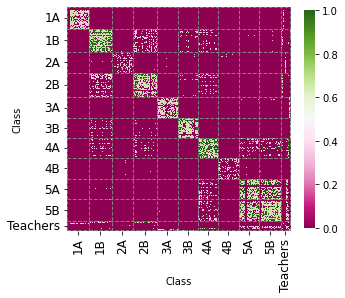

In [279]:
plt.figure(figsize=(5,5))  

# Plot heatmap with the updated labels
sns.heatmap(P_est, square=True, cmap="PiYG", cbar=True, cbar_kws={"shrink": 0.8})

# Add gridlines at the change positions
for pos in change_positions:
    plt.axvline(x=pos, color='grey', linestyle='--', linewidth=1)  # Vertical gridlines
    plt.axhline(y=pos, color='grey', linestyle='--', linewidth=1)  # Horizontal gridlines

# Set the xticks and yticks to the middle of the gridlines
plt.xticks(middle_positions, middle_labels, rotation=90, fontsize=12)
plt.yticks(middle_positions, middle_labels, rotation=0, fontsize=12)

plt.ylabel('Class', labelpad=-15)
plt.xlabel('Class', labelpad=-15)

# plt.title('Adjacency Matrix of Primary School Interaction \n Network at 9:00-10:00 of Day 1', fontsize=12, pad=10)

# plt.savefig('figs/Phat_matrix_A1_heatmap_PiYG.png', dpi=300, bbox_inches='tight', facecolor='white')

# Show the plot
plt.show()

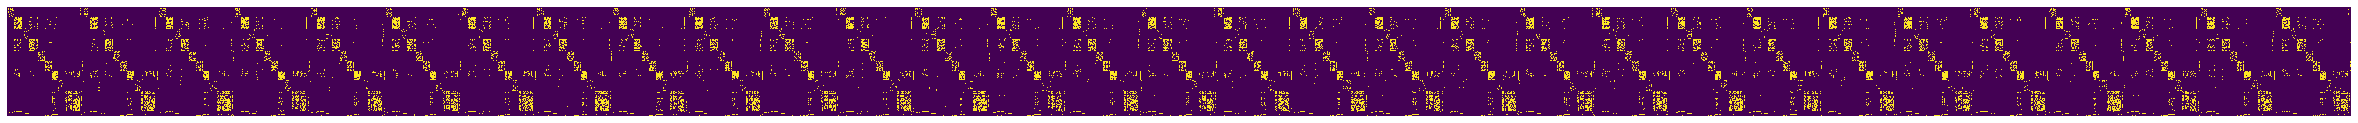

In [280]:
reshaped_A = np.hstack(A_list)

plt.figure(figsize=(42, 2))  # Set figure size as needed

sns.heatmap(reshaped_A, cmap="viridis", cbar=False)

# Disable x and y ticks
plt.xticks([])  # Remove x ticks
plt.yticks([])  # Remove y ticks

# plt.savefig("figs/school_A1_Aboots_heatmap_viridis.png", dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

### Try different perplexity values in TSNE

Already generated B=20 bootstraps. 

The first cell below then needs to use the UASE of the obs and B=20 bootstraps to estimate `in_cov_friends_symm`, the ``similarity matrix $U$''

In [281]:
print(f"B={B}, d={d}, k={k}")

B=30, d=12, k=3


In [355]:
""""create this weird new adjacency matrix"""
in_cov_friends = np.zeros((n,n))

for i in range(n):
    # Filter data for node number and select the relevant dimensions
    node_number = i
    data_d_dim = yadf[yadf["NodeNumber"] == node_number].iloc[:, 0:d].to_numpy()

    # Calculate the mean and covariance considering all d dimensions
    mean_d_dim = np.mean(data_d_dim, axis=0)
    cov_d_dim = np.cov(data_d_dim, rowvar=False)

    # Use the point corresponding to the specific node_number in matrix 0 as the center
    point = data_d_dim[0]
    obs_points = yadf[yadf["Matrix"] == 0].iloc[:, 0:d].to_numpy()

    # Plotting only the first two dimensions
    data_2d = data_d_dim[:, 0:2]
    obs_points_2d = obs_points[:, 0:2]

    # Filter points within the ellipse
    inside_ellipse = points_within_ellipse(obs_points_2d, point[:2], cov_d_dim[:2, :2])

    # Extract node numbers for points inside the ellipse
    node_numbers_inside_ellipse = yadf[yadf["Matrix"] == 0].iloc[inside_ellipse].index.tolist()

    # set in_cov_friends[i, node_numbers_inside_ellipse] = 1
    in_cov_friends[i, node_numbers_inside_ellipse] = 1

    # symmetrize the matrix in_cov_friends - 
# minimum means both must be 1
# maximum means at least one must be 1
in_cov_friends_symm = np.minimum(in_cov_friends, in_cov_friends.T)
# sns.heatmap(in_cov_friends_symm, square=True)

/tmp/ipykernel_143816/833278009.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Aobs_yadf[["Dimension_1", "Dimension_2"]] = scaler.fit_transform(Aobs_yadf[["Dimension_1", "Dimension_2"]])


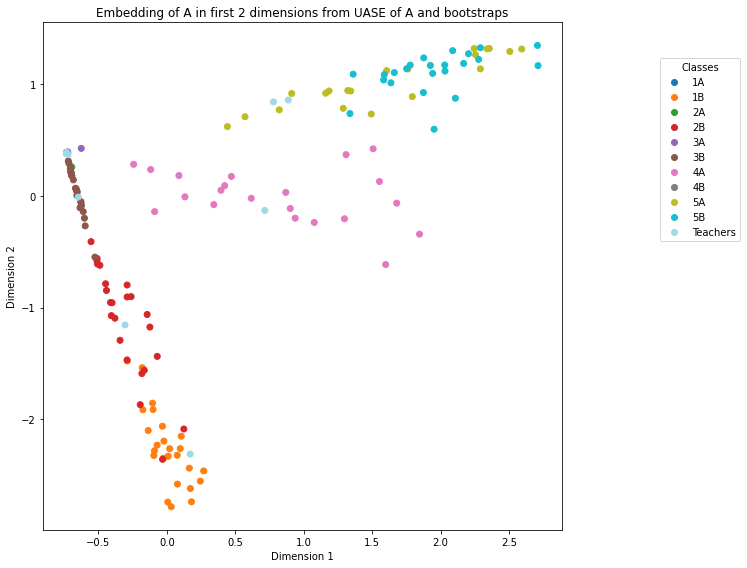

In [356]:
# Create a figure and axis object
fig, ax = plt.subplots(figsize=(8,8))

Aobs_yadf = yadf[yadf["Matrix"] == 0]

# Standardize the data in the Dimension_1 and Dimension_2 columns - so Dimension_1 and Dimension_2 have mean 0 and standard deviation 1
scaler = StandardScaler()
# Fit the scaler on the Dimension columns and transform them
Aobs_yadf[["Dimension_1", "Dimension_2"]] = scaler.fit_transform(Aobs_yadf[["Dimension_1", "Dimension_2"]])

# Plot the scatter plot
scatter = ax.scatter(Aobs_yadf["Dimension_1"], Aobs_yadf["Dimension_2"], c=Aobs_yadf["tau"], cmap='tab20')
ax.set_xlabel("Dimension 1")
ax.set_ylabel("Dimension 2")

# Set the title
ax.set_title(f"Embedding of A in first 2 dimensions from UASE of A and bootstraps")  

# Add legend for classes, mapping the integer labels back to the label_dict keys
handles, labels_legend = scatter.legend_elements()
label_dict_inv = {v: k for k, v in label_dict.items()}  # Inverse mapping
mapped_labels = []
for label in labels_legend:
    match = re.search(r'\d+', label)
    if match:
        numeric_label = int(match.group(0))
        mapped_labels.append(label_dict_inv.get(numeric_label, "Unknown"))

# Add the legend with the mapped labels
fig.legend(handles, mapped_labels, title="Classes", loc="upper right", bbox_to_anchor=(1.3, 0.9))

# Adjust layout to make room for titles and labels
plt.tight_layout()

# plt.savefig("school_A1_embedA_viaUASE_sd1mean0.png", bbox_inches='tight', facecolor='white')

# Show the combined plot
plt.show()


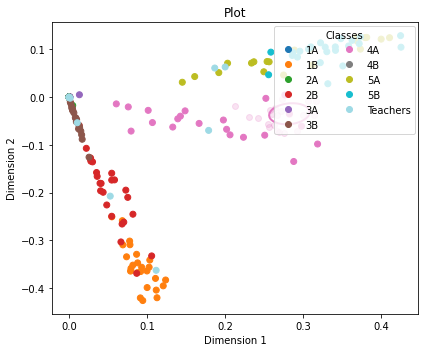

In [372]:
# Create a figure and axis object
fig, ax = plt.subplots(figsize=(6,5))

Aobs_yadf = yadf[yadf["Matrix"] == 0]

node_number = 151

Aobs_yadf_node = Aobs_yadf[Aobs_yadf["NodeNumber"] == node_number]

# Plot the scatter plot
scatter = ax.scatter(Aobs_yadf["Dimension_1"], Aobs_yadf["Dimension_2"], c=Aobs_yadf["tau"], cmap='tab20')
ax.set_xlabel("Dimension 1")
ax.set_ylabel("Dimension 2")

# Filter data for node number and select the relevant dimensions
data_d_dim = yadf[yadf["NodeNumber"] == node_number].iloc[:, 0:d].to_numpy()

# plot the bootstrap points
ax.scatter(data_d_dim[:, 0], data_d_dim[:, 1], color='#e377c2', alpha=0.2)

# Calculate the covariance considering all d dimensions
cov_d_dim = np.cov(data_d_dim, rowvar=False)

# plot the covariance ellipse with the same color as the point
plot_ellipse(ax, data_d_dim[0, :2], cov_d_dim[:2, :2], color='#e377c2')

# Set the title
ax.set_title(f"Plot")  

# Add legend for classes, mapping the integer labels back to the label_dict keys
handles, labels_legend = scatter.legend_elements()
label_dict_inv = {v: k for k, v in label_dict.items()}  # Inverse mapping
mapped_labels = []
for label in labels_legend:
    match = re.search(r'\d+', label)
    if match:
        numeric_label = int(match.group(0))
        mapped_labels.append(label_dict_inv.get(numeric_label, "Unknown"))

# Add the legend with the mapped labels
fig.legend(handles, mapped_labels, title="Classes", loc="upper right", bbox_to_anchor=(0.98, 0.93), ncols=2)

# Adjust layout to make room for titles and labels
plt.tight_layout()

# plt.savefig("figs/school_A1_embedA_viaUASE_sd1mean0_node151highlight.png", bbox_inches='tight', facecolor='white')

# Show the combined plot
plt.show()

In [304]:
def plot_ellipse_3mahals(ax, mean, cov, color='blue', lw=1):
    """
    Plot an ellipse representing the covariance matrix.
    
    Parameters:
    - ax: matplotlib axis to plot on.
    - mean: 2D array for the center of the ellipse.
    - cov: 2x2 covariance matrix.
    - color: Color of the ellipse.
    - lw: Line width.
    """
    # Eigenvalues and eigenvectors for the covariance matrix
    vals, vecs = np.linalg.eigh(cov)
    
    # Sort the eigenvalues and corresponding eigenvectors in descending order
    order = vals.argsort()[::-1]
    vals = vals[order]
    vecs = vecs[:, order]
    
    # Calculate angle of ellipse based on largest eigenvector
    angle = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
    
    # Define standard deviations to plot (1, 2, and 3 SDs)
    std_devs = [1, 2, 3]
    
    for std_dev in std_devs:
        # Width and height of ellipse correspond to 2*sqrt(eigenvalue)
        width, height = 2 * std_dev * np.sqrt(vals)
        
        # Create and add ellipse patch
        ell = Ellipse(xy=mean, width=width, height=height, angle=angle, 
                      color=color, lw=lw, fill=False, alpha=0.8)
        ax.add_patch(ell)


def plot_ellipse_3rd_mahals(ax, mean, cov, color='blue', lw=1):
    """
    Plot an ellipse representing the covariance matrix.
    
    Parameters:
    - ax: matplotlib axis to plot on.
    - mean: 2D array for the center of the ellipse.
    - cov: 2x2 covariance matrix.
    - color: Color of the ellipse.
    - lw: Line width.
    """
    # Eigenvalues and eigenvectors for the covariance matrix
    vals, vecs = np.linalg.eigh(cov)
    
    # Sort the eigenvalues and corresponding eigenvectors in descending order
    order = vals.argsort()[::-1]
    vals = vals[order]
    vecs = vecs[:, order]
    
    # Calculate angle of ellipse based on largest eigenvector
    angle = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
    
    std_dev = 3
    # Width and height of ellipse correspond to 2*sqrt(eigenvalue)
    width, height = 2 * std_dev * np.sqrt(vals)
    
    # Create and add ellipse patch
    ell = Ellipse(xy=mean, width=width, height=height, angle=angle, 
                    color=color, lw=lw, fill=False, alpha=0.8)
    ax.add_patch(ell)

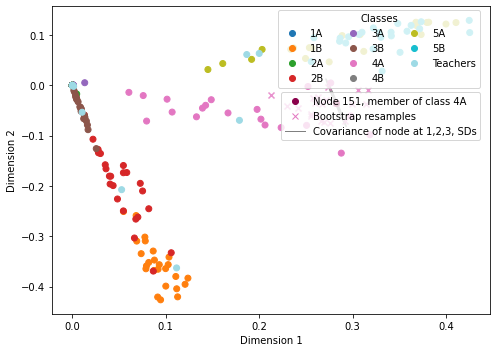

In [358]:
# Create a figure and axis object
fig, ax = plt.subplots(figsize=(7,5))

Aobs_yadf = yadf[yadf["Matrix"] == 0]

node_number = 151

Aobs_yadf_node = Aobs_yadf[Aobs_yadf["NodeNumber"] == node_number]

# Filter data for node number and select the relevant dimensions
data_d_dim = yadf[yadf["NodeNumber"] == node_number].iloc[:, 0:d].to_numpy()

# plot the covariance ellipse with the same color as the point
plot_ellipse_3mahals(ax, data_d_dim[0, :2], cov_d_dim[:2, :2], color='#808080', lw=1)

# Plot the scatter plot
scatter = ax.scatter(Aobs_yadf["Dimension_1"], Aobs_yadf["Dimension_2"], c=Aobs_yadf["tau"], cmap='tab20')
ax.set_xlabel("Dimension 1")
ax.set_ylabel("Dimension 2")

# plot the bootstrap points
ax.scatter(data_d_dim[:, 0], data_d_dim[:, 1], color='#e377c2', alpha=0.8, marker='x')
# Plot a ring around the node
ax.scatter(data_d_dim[0, 0], data_d_dim[0, 1], facecolor='#8B004B', edgecolor='#8B004B', marker='o', linewidth=1)

# Calculate the covariance considering all d dimensions
cov_d_dim = np.cov(data_d_dim, rowvar=False)

# Set the title
# ax.set_title(f"Plot")  

# Add legend for classes, mapping the integer labels back to the label_dict keys
handles, labels_legend = scatter.legend_elements()
label_dict_inv = {v: k for k, v in label_dict.items()}  # Inverse mapping
mapped_labels = []
for label in labels_legend:
    match = re.search(r'\d+', label)
    if match:
        numeric_label = int(match.group(0))
        mapped_labels.append(label_dict_inv.get(numeric_label, "Unknown"))

# Add the legend with the mapped labels
fig.legend(handles, mapped_labels, title="Classes", loc="upper right", bbox_to_anchor=(0.97, 0.975), ncols=3)

# Create custom second legend
legend_elements = [
    Line2D([0], [0], color='#8B004B', marker='o', lw=0, label=f'Node {node_number}, member of class 4A', markersize=6, markerfacecolor='#8B004B', markeredgewidth=1),
    Line2D([0], [0], color='#e377c2', marker='x', lw=0, label='Bootstrap resamples', markersize=6, markerfacecolor='#e377c2'),
    Line2D([0], [0], color='#808080', lw=1, label='Covariance of node at 1,2,3, SDs', linestyle='-')
]
fig.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.97, 0.745))

# Adjust layout to make room for titles and labels
plt.tight_layout()

# plt.savefig("figs/school_A1_embedA_viaUASE_sd1mean0_node151highlight_3mahals.png", bbox_inches='tight', facecolor='white')

# Show the combined plot
plt.show()

/tmp/ipykernel_143816/2862399928.py:22: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(node151friends["Dimension_1"], node151friends["Dimension_2"], c='#e377c2', cmap='tab20')


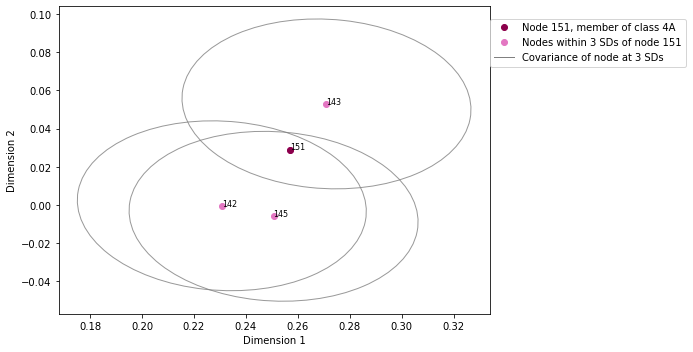

In [328]:
# Create a figure and axis object
fig, ax = plt.subplots(figsize=(7,5))

Aobs_yadf = yadf[yadf["Matrix"] == 0]

og_node_number = 151
selected_nodes = [151, 143, 142, 145]

class4A = Aobs_yadf[Aobs_yadf["tau"] == 6]
node151friends = class4A[class4A["NodeNumber"].isin(selected_nodes)]

Aobs_yadf_node = Aobs_yadf[Aobs_yadf["NodeNumber"] == node_number]


for i in range(1, len(selected_nodes)):
    node_number = selected_nodes[i]
    data_d_dim = yadf[yadf["NodeNumber"] == node_number].iloc[:, 0:d].to_numpy()
    plot_ellipse_3rd_mahals(ax, data_d_dim[0, :2], cov_d_dim[:2, :2], color='#808080', lw=1)
    

# Plot the scatter plot
scatter = ax.scatter(node151friends["Dimension_1"], node151friends["Dimension_2"], c='#e377c2', cmap='tab20')

# Filter data for node number and select the relevant dimensions
data_d_dim = yadf[yadf["NodeNumber"] == og_node_number].iloc[:, 0:d].to_numpy()
ax.scatter(data_d_dim[0, 0], data_d_dim[0, 1], facecolor='#8B004B', edgecolor='#8B004B', marker='o', linewidth=1)

# Label the node numbers next to each point in class4A
for i, row in node151friends.iterrows():
    ax.text(row["Dimension_1"], row["Dimension_2"], str(int(row["NodeNumber"])), fontsize=8, color='black')

ax.set_xlabel("Dimension 1")
ax.set_ylabel("Dimension 2")

# Create custom second legend
legend_elements = [
    Line2D([0], [0], color='#8B004B', marker='o', lw=0, label=f'Node {og_node_number}, member of class 4A', markersize=6, markerfacecolor='#8B004B', markeredgewidth=1),
    Line2D([0], [0], color='#e377c2', marker='o', lw=0, label=f'Nodes within 3 SDs of node {og_node_number}', markersize=6, markerfacecolor='#e377c2'),
    Line2D([0], [0], color='#808080', lw=1, label='Covariance of node at 3 SDs', linestyle='-')
]
fig.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0.97, 0.95))

plt.tight_layout()

plt.show()

/tmp/ipykernel_143816/2520948907.py:19: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(class2B["Dimension_1"], class2B["Dimension_2"], c='#e377c2', cmap='tab20')
/home/uj21900/anaconda3/lib/python3.9/site-packages/matplotlib/collections.py:1109: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


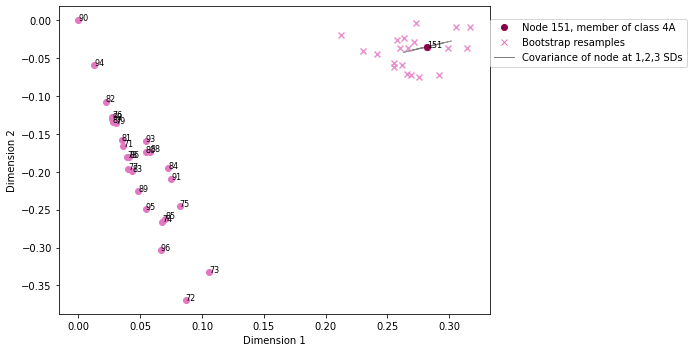

In [371]:
# Create a figure and axis object
fig, ax = plt.subplots(figsize=(7,5))

Aobs_yadf = yadf[yadf["Matrix"] == 0]

node_number = 151

class2B = Aobs_yadf[(Aobs_yadf["tau"] == 3)]

Aobs_yadf_node = Aobs_yadf[Aobs_yadf["NodeNumber"] == node_number]

# Filter data for node number and select the relevant dimensions
data_d_dim = yadf[yadf["NodeNumber"] == node_number].iloc[:, 0:d].to_numpy()

# Plot the covariance ellipse with the same color as the point
plot_ellipse_3mahals(ax, data_d_dim[0, :2], cov_d_dim[:2, :2], color='#808080', lw=1)

# Plot the scatter plot
scatter = ax.scatter(class2B["Dimension_1"], class2B["Dimension_2"], c='#e377c2', cmap='tab20')
ax.set_xlabel("Dimension 1")
ax.set_ylabel("Dimension 2")

# Plot the bootstrap points
ax.scatter(data_d_dim[:, 0], data_d_dim[:, 1], color='#e377c2', alpha=0.8, marker='x')

# Plot a ring around the node
ax.scatter(data_d_dim[0, 0], data_d_dim[0, 1], facecolor='#8B004B', edgecolor='#8B004B', marker='o', linewidth=1)

# Calculate the covariance considering all d dimensions
cov_d_dim = np.cov(data_d_dim, rowvar=False)

# Label the node numbers next to each point in class2B
for i, row in class2B.iterrows():
    ax.text(row["Dimension_1"], row["Dimension_2"], str(int(row["NodeNumber"])), fontsize=8, color='black')

# Also label the node number of the highlighted node
ax.text(data_d_dim[0, 0], data_d_dim[0, 1], str(node_number), fontsize=8, color='black')

# Add legend for classes, mapping the integer labels back to the label_dict keys
handles, labels_legend = scatter.legend_elements()
label_dict_inv = {v: k for k, v in label_dict.items()}  # Inverse mapping
mapped_labels = []
for label in labels_legend:
    match = re.search(r'\d+', label)
    if match:
        numeric_label = int(match.group(0))
        mapped_labels.append(label_dict_inv.get(numeric_label, "Unknown"))

# Create custom second legend
legend_elements = [
    Line2D([0], [0], color='#8B004B', marker='o', lw=0, label=f'Node {node_number}, member of class 4A', markersize=6, markerfacecolor='#8B004B', markeredgewidth=1),
    Line2D([0], [0], color='#e377c2', marker='x', lw=0, label='Bootstrap resamples', markersize=6, markerfacecolor='#e377c2'),
    Line2D([0], [0], color='#808080', lw=1, label='Covariance of node at 1,2,3 SDs', linestyle='-')
]
fig.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0.97, 0.95))

# Adjust layout to make room for titles and labels
plt.tight_layout()

plt.show()


/tmp/ipykernel_143816/2289438262.py:26: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(class4A["Dimension_1"], class4A["Dimension_2"], c='#e377c2', cmap='tab20', alpha=0.8)


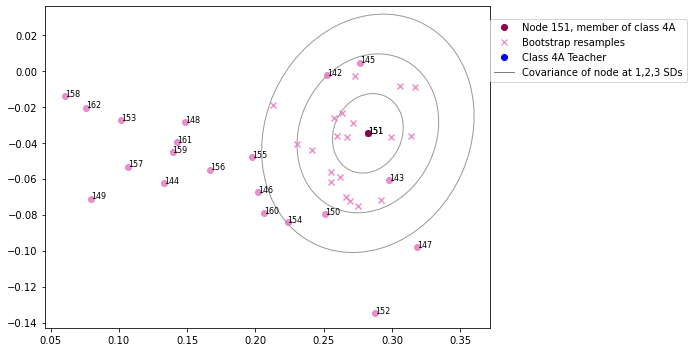

In [344]:
# Create a figure and axis object
fig, ax = plt.subplots(figsize=(7, 5))

Aobs_yadf = yadf[yadf["Matrix"] == 0]

node_number = 151

class4A = Aobs_yadf[(Aobs_yadf["tau"] == 6)]

# Define the teacher's node number
teacher_node_number = 239 # Replace with the actual teacher node number if known
teacher_row = class4A[class4A["NodeNumber"] == teacher_node_number]

Aobs_yadf_node = Aobs_yadf[Aobs_yadf["NodeNumber"] == node_number]

# Filter data for node number and select the relevant dimensions
data_d_dim = yadf[yadf["NodeNumber"] == node_number].iloc[:, 0:d].to_numpy()

# Calculate covariance considering all d dimensions
cov_d_dim = np.cov(data_d_dim, rowvar=False)

# Plot the covariance ellipse with the same color as the point
plot_ellipse_3mahals(ax, data_d_dim[0, :2], cov_d_dim[:2, :2], color='#808080', lw=1)

# Plot the scatter plot for class4A
scatter = ax.scatter(class4A["Dimension_1"], class4A["Dimension_2"], c='#e377c2', cmap='tab20', alpha=0.8)

# Plot the bootstrap points
ax.scatter(data_d_dim[:, 0], data_d_dim[:, 1], color='#e377c2', alpha=0.8, marker='x')

# Plot a ring around the node
ax.scatter(data_d_dim[0, 0], data_d_dim[0, 1], facecolor='#8B004B', edgecolor='#8B004B', marker='o', linewidth=1)

# Plot the teacher's point in blue if it exists in class4A
if not teacher_row.empty:
    ax.scatter(teacher_row["Dimension_1"].values[0], teacher_row["Dimension_2"].values[0], 
               color='blue', marker='o', s=100, label='Class 4A Teacher')  # Adjust size with 's'

# Label the node numbers next to each point in class4A
for i, row in class4A.iterrows():
    ax.text(row["Dimension_1"], row["Dimension_2"], str(int(row["NodeNumber"])), fontsize=8, color='black')

# Also label the node number of the highlighted node
ax.text(data_d_dim[0, 0], data_d_dim[0, 1], str(node_number), fontsize=8, color='black')

# Add legend for classes, mapping the integer labels back to the label_dict keys
handles, labels_legend = scatter.legend_elements()
label_dict_inv = {v: k for k, v in label_dict.items()}  # Inverse mapping
mapped_labels = []
for label in labels_legend:
    match = re.search(r'\d+', label)
    if match:
        numeric_label = int(match.group(0))
        mapped_labels.append(label_dict_inv.get(numeric_label, "Unknown"))

# Create custom second legend
legend_elements = [
    Line2D([0], [0], color='#8B004B', marker='o', lw=0, label=f'Node {node_number}, member of class 4A', markersize=6, markerfacecolor='#8B004B', markeredgewidth=1),
    Line2D([0], [0], color='#e377c2', marker='x', lw=0, label='Bootstrap resamples', markersize=6, markerfacecolor='#e377c2'),
    Line2D([0], [0], color='blue', marker='o', lw=0, label='Class 4A Teacher', markersize=6),
    Line2D([0], [0], color='#808080', lw=1, label='Covariance of node at 1,2,3 SDs', linestyle='-')
]
fig.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0.97, 0.95))

# Adjust layout to make room for titles and labels
plt.tight_layout()

# Show the combined plot
plt.show()


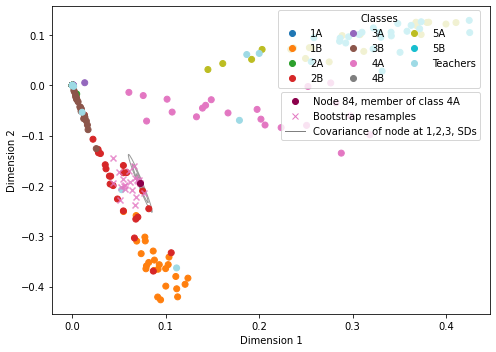

In [378]:
# Create a figure and axis object
fig, ax = plt.subplots(figsize=(7,5))

Aobs_yadf = yadf[yadf["Matrix"] == 0]

node_number = 84

Aobs_yadf_node = Aobs_yadf[Aobs_yadf["NodeNumber"] == node_number]

# Filter data for node number and select the relevant dimensions
data_d_dim = yadf[yadf["NodeNumber"] == node_number].iloc[:, 0:d].to_numpy()

# plot the covariance ellipse with the same color as the point
plot_ellipse_3mahals(ax, data_d_dim[0, :2], cov_d_dim[:2, :2], color='#808080', lw=1)

# Plot the scatter plot
scatter = ax.scatter(Aobs_yadf["Dimension_1"], Aobs_yadf["Dimension_2"], c=Aobs_yadf["tau"], cmap='tab20')
ax.set_xlabel("Dimension 1")
ax.set_ylabel("Dimension 2")

# plot the bootstrap points
ax.scatter(data_d_dim[:, 0], data_d_dim[:, 1], color='#e377c2', alpha=0.8, marker='x')
# Plot a ring around the node
ax.scatter(data_d_dim[0, 0], data_d_dim[0, 1], facecolor='#8B004B', edgecolor='#8B004B', marker='o', linewidth=1)

# Calculate the covariance considering all d dimensions
cov_d_dim = np.cov(data_d_dim, rowvar=False)

# Set the title
# ax.set_title(f"Plot")  

# Add legend for classes, mapping the integer labels back to the label_dict keys
handles, labels_legend = scatter.legend_elements()
label_dict_inv = {v: k for k, v in label_dict.items()}  # Inverse mapping
mapped_labels = []
for label in labels_legend:
    match = re.search(r'\d+', label)
    if match:
        numeric_label = int(match.group(0))
        mapped_labels.append(label_dict_inv.get(numeric_label, "Unknown"))

# Add the legend with the mapped labels
fig.legend(handles, mapped_labels, title="Classes", loc="upper right", bbox_to_anchor=(0.97, 0.975), ncols=3)

# Create custom second legend
legend_elements = [
    Line2D([0], [0], color='#8B004B', marker='o', lw=0, label=f'Node {node_number}, member of class 4A', markersize=6, markerfacecolor='#8B004B', markeredgewidth=1),
    Line2D([0], [0], color='#e377c2', marker='x', lw=0, label='Bootstrap resamples', markersize=6, markerfacecolor='#e377c2'),
    Line2D([0], [0], color='#808080', lw=1, label='Covariance of node at 1,2,3, SDs', linestyle='-')
]
fig.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.97, 0.745))

# Adjust layout to make room for titles and labels
plt.tight_layout()

# plt.savefig("figs/school_A1_embedA_viaUASE_sd1mean0_node151highlight_3mahals.png", bbox_inches='tight', facecolor='white')

# Show the combined plot
plt.show()

### Different perplexity values

B fixed and the $U$ matrix already calculated from the UASE

ValueError: 'bottom center' is not a valid value for loc; supported values are 'best', 'upper right', 'upper left', 'lower left', 'lower right', 'right', 'center left', 'center right', 'lower center', 'upper center', 'center'

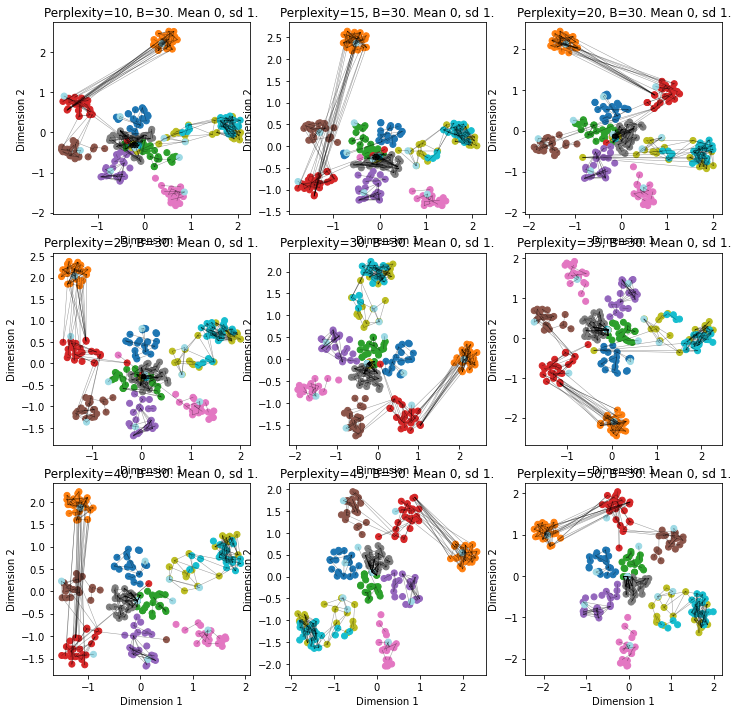

In [289]:
# Define the list of perplexity values
perp_values = [10, 15, 20, 25, 30, 35, 40, 45, 50]

# Set up the 3x3 subplot grid
fig, axs = plt.subplots(3, 3, figsize=(12, 12))

# Iterate over the perplexity values and subplot indices
for idx, perp_val in enumerate(perp_values):
    # Create the t-SNE embedding
    tsne = TSNE(n_components=2, perplexity=perp_val, random_state=0)
    # tSNE the true adjacency matrix
    A_tsne = tsne.fit_transform(dense_adj)

    # Convert to DataFrame
    A_tsne_df = pd.DataFrame(A_tsne)
    A_tsne_df.columns = ["Dimension_{}".format(i+1) for i in range(A_tsne_df.shape[1])]
    A_tsne_df["tau"] = np.tile(node_labels, 1)

    # Standardize the data in the Dimension_1 and Dimension_2 columns - mean 0, sd 1
    scaler = StandardScaler()
    # Fit the scaler on the Dimension columns and transform them
    A_tsne_df[["Dimension_1", "Dimension_2"]] = scaler.fit_transform(A_tsne_df[["Dimension_1", "Dimension_2"]])


    # Select the subplot
    ax = axs[idx // 3, idx % 3]

    # Plot the scatter plot
    scatter = ax.scatter(A_tsne_df["Dimension_1"], A_tsne_df["Dimension_2"], c=A_tsne_df["tau"], cmap='tab20')
    ax.set_xlabel("Dimension 1", fontsize=10)
    ax.set_ylabel("Dimension 2", fontsize=10)

    # Draw lines between connected nodes based on the "friends" matrix, U
    # AND calculate the total euclidean distance that the lines connecting the nodes in the tSNE plot cover
    total_distance = 0
    for i in range(len(A_tsne_df)):
        for j in range(i + 1, len(A_tsne_df)):
            if in_cov_friends_symm[i, j] == 1:  # Check if nodes i and j are connected
                ax.plot([A_tsne_df["Dimension_1"].iloc[i], A_tsne_df["Dimension_1"].iloc[j]], 
                        [A_tsne_df["Dimension_2"].iloc[i], A_tsne_df["Dimension_2"].iloc[j]], 
                        'k-', lw=0.5, alpha=0.4)  # Draw a line between them
                # add this euclidean distance to the total_distance
                total_distance += np.linalg.norm(A_tsne_df[["Dimension_1", "Dimension_2"]].iloc[i] - A_tsne_df[["Dimension_1", "Dimension_2"]].iloc[j])

    total_distance = round(total_distance, 2)
    
    # title
    ax.set_title(f"Perplexity={perp_val}, B={B}. Mean 0, sd 1.", fontsize=12)# \n Total Euclidean Distance of lines is {total_distance} \n points are tSNE(A) with different perplexities")



# Add legend for classes, mapping the integer labels back to the label_dict keys
handles, labels_legend = scatter.legend_elements()
label_dict_inv = {v: k for k, v in label_dict.items()}  
mapped_labels = []
for label in labels_legend:
    match = re.search(r'\d+', label)
    if match:
        numeric_label = int(match.group(0))
        mapped_labels.append(label_dict_inv[numeric_label])
fig.legend(handles, mapped_labels, title="Classes", loc="bottom center", ncols=3, bbox_to_anchor=(1.1, 0.63))

# Adjust layout to make room for titles and labels
plt.tight_layout()

# plt.savefig("figs/schoolA0_tsne_perplexity_B20_plot_PCA(A)_mean0sd1.png", facecolor='white')

# Show the combined plot
plt.show()

### Fix perplexity and change B

100%|██████████| 50/50 [00:04<00:00, 10.49it/s]


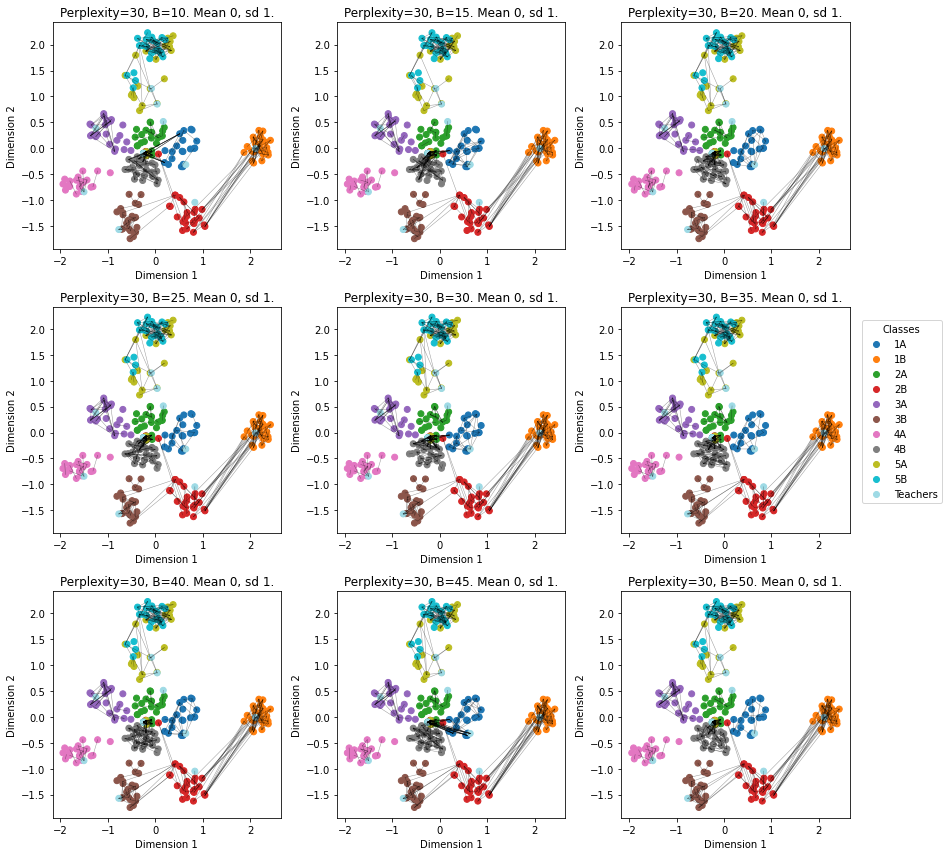

In [298]:
# Example setup for perplexity
perp_val = 30

# tSNE Aobs
tsne = TSNE(n_components=2, perplexity=perp_val, random_state=0)
# tSNE the embedding of just the true adjacency matrix
A_tsne = tsne.fit_transform(dense_adj)

# Convert to DataFrame
A_tsne_df = pd.DataFrame(A_tsne)
A_tsne_df.columns = ["Dimension_{}".format(i+1) for i in range(A_tsne_df.shape[1])]
A_tsne_df["tau"] = np.tile(node_labels, 1)

# Standardize the data in the Dimension_1 and Dimension_2 columns
scaler = StandardScaler()
A_tsne_df[["Dimension_1", "Dimension_2"]] = scaler.fit_transform(A_tsne_df[["Dimension_1", "Dimension_2"]])


# Assume B_values and other required variables like 'yhat', 'node_labels', 'in_cov_friends_symm' are already defined.
B_values = range(10, 51, 5)  # Example B values

# Set up the 3x3 subplot grid
fig, axs = plt.subplots(3, 3, figsize=(12,12))

# Iterate over B values with an index
for idx, B in enumerate(B_values):

    A_boots_list = []

    for b in tqdm(range(B)):
        _, A_boots = create_single_kNN_bootstrap(dense_adj, d=d, Q=1000, n_neighbors=k)
        A_boots_list.append(A_boots)

    A_list = [dense_adj] + A_boots_list
    yhat = UASE(A_list, d=d, sparse_matrix=False)

    yadf = pd.DataFrame(yhat)

    # rename the columns - this is called a list comprehension
    yadf.columns = ["Dimension_{}".format(i+1) for i in range(yadf.shape[1])] 

    # repeats tau list the len of A_true_boots_list times
    yadf["tau"] = np.tile(node_labels, B + 1)

    # add column for the matrix it is
    yadf["Matrix"] = np.repeat(range(B+1), len(node_labels))

    # repeat range(len(node_labels)) B+1 times to give each node a unique number
    yadf['NodeNumber'] = list(range(len(node_labels)))*(B+1)


    """"create this weird new uncertainty adjacency matrix using this many B bootstraps"""
    in_cov_friends = np.zeros((n,n))

    for i in range(n):
        # Filter data for node number and select the relevant dimensions
        node_number = i
        data_d_dim = yadf[yadf["NodeNumber"] == node_number].iloc[:, 0:d].to_numpy()

        # Calculate the mean and covariance considering all d dimensions
        mean_d_dim = np.mean(data_d_dim, axis=0)
        cov_d_dim = np.cov(data_d_dim, rowvar=False)

        # Use the point corresponding to the specific node_number in matrix 0 as the center
        point = data_d_dim[0]
        obs_points = yadf[yadf["Matrix"] == 0].iloc[:, 0:d].to_numpy()

        # Plotting only the first two dimensions
        data_2d = data_d_dim[:, 0:2]
        obs_points_2d = obs_points[:, 0:2]

        # Filter points within the ellipse
        inside_ellipse = points_within_ellipse(obs_points_2d, point[:2], cov_d_dim[:2, :2])

        # Extract node numbers for points inside the ellipse
        node_numbers_inside_ellipse = yadf[yadf["Matrix"] == 0].iloc[inside_ellipse].index.tolist()

        # set in_cov_friends[i, node_numbers_inside_ellipse] = 1
        in_cov_friends[i, node_numbers_inside_ellipse] = 1

        # symmetrize the matrix in_cov_friends - 
    # minimum means both must be 1
    # maximum means at least one must be 1
    in_cov_friends_symm = np.minimum(in_cov_friends, in_cov_friends.T)
    # sns.heatmap(in_cov_friends_symm, square=True)


    # Select the subplot
    ax = axs[idx // 3, idx % 3]

    # Plot the scatter plot
    scatter = ax.scatter(A_tsne_df["Dimension_1"], A_tsne_df["Dimension_2"], c=A_tsne_df["tau"], cmap='tab20')
    ax.set_xlabel("Dimension 1", fontsize=10)
    ax.set_ylabel("Dimension 2", fontsize=10)

    # Draw lines between connected nodes based on the adjacency matrix
    # AND calculate the total euclidean distance that the lines connecting the nodes in the tSNE plot cover
    total_distance = 0
    for i in range(len(A_tsne_df)):
        for j in range(i + 1, len(A_tsne_df)):
            if in_cov_friends_symm[i, j] == 1:  # Check if nodes i and j are connected
                ax.plot([A_tsne_df["Dimension_1"].iloc[i], A_tsne_df["Dimension_1"].iloc[j]], 
                        [A_tsne_df["Dimension_2"].iloc[i], A_tsne_df["Dimension_2"].iloc[j]], 
                        'k-', lw=0.5, alpha=0.4)  # Draw a line between them
                # add this euclidean distance to the total_distance
                total_distance += np.linalg.norm(A_tsne_df[["Dimension_1", "Dimension_2"]].iloc[i] - A_tsne_df[["Dimension_1", "Dimension_2"]].iloc[j])

    total_distance = round(total_distance, 2)

    # title
    ax.set_title(f"Perplexity={perp_val}, B={B}. Mean 0, sd 1.", fontsize=12)#  \n Total Euclidean Distance of lines is {total_distance} \n  {B} bootstraps used to estimate $U$, points are tSNE(A)")  
    # Now this will correctly reflect B


# Add legend for classes, mapping the integer labels back to the label_dict keys
handles, labels_legend = scatter.legend_elements()
label_dict_inv = {v: k for k, v in label_dict.items()}  
mapped_labels = []
for label in labels_legend:
    match = re.search(r'\d+', label)
    if match:
        numeric_label = int(match.group(0))
        mapped_labels.append(label_dict_inv[numeric_label])
fig.legend(handles, mapped_labels, title="Classes", loc="bottom center", ncols=3, bbox_to_anchor=(1.1, 0.63))

# Adjust layout to make room for titles and labels
plt.tight_layout()

# plt.savefig(f"figs/school_A1_tsne_perp{perp_val}_B{B}_plot_tsne(A)_mean0sd1.png", bbox_inches='tight', facecolor='white')

# Show the combined plot
plt.show()


100%|██████████| 20/20 [00:02<00:00,  8.91it/s]


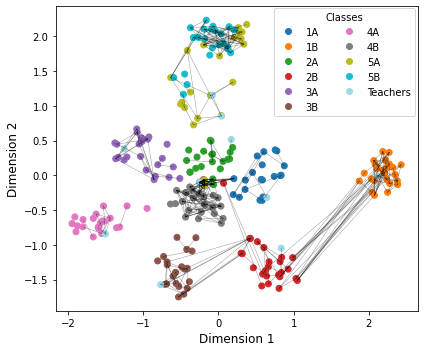

In [270]:
# Set the perplexity value
perp_val = 30

# tSNE Aobs
tsne = TSNE(n_components=2, perplexity=perp_val, random_state=0)
# tSNE the embedding of just the true adjacency matrix
A_tsne = tsne.fit_transform(dense_adj)

# Convert to DataFrame
A_tsne_df = pd.DataFrame(A_tsne)
A_tsne_df.columns = ["Dimension_{}".format(i+1) for i in range(A_tsne_df.shape[1])]
A_tsne_df["tau"] = np.tile(node_labels, 1)

# Standardize the data in the Dimension_1 and Dimension_2 columns
scaler = StandardScaler()
A_tsne_df[["Dimension_1", "Dimension_2"]] = scaler.fit_transform(A_tsne_df[["Dimension_1", "Dimension_2"]])

# Assume B=20 and other required variables like 'yhat', 'node_labels', 'in_cov_friends_symm' are already defined.
B = 20

A_boots_list = []

for b in tqdm(range(B)):
    _, A_boots = create_single_kNN_bootstrap(dense_adj, d=d, Q=1000, n_neighbors=k)
    A_boots_list.append(A_boots)

A_list = [dense_adj] + A_boots_list
yhat = UASE(A_list, d=d, sparse_matrix=False)

yadf = pd.DataFrame(yhat)

# Rename the columns - this is called a list comprehension
yadf.columns = ["Dimension_{}".format(i+1) for i in range(yadf.shape[1])] 

# Repeat tau list the length of A_true_boots_list times
yadf["tau"] = np.tile(node_labels, B + 1)

# Add column for the matrix it is
yadf["Matrix"] = np.repeat(range(B+1), len(node_labels))

# Repeat range(len(node_labels)) B+1 times to give each node a unique number
yadf['NodeNumber'] = list(range(len(node_labels)))*(B+1)


""""Create the new uncertainty adjacency matrix using this many B bootstraps"""
in_cov_friends = np.zeros((n, n))

for i in range(n):
    # Filter data for node number and select the relevant dimensions
    node_number = i
    data_d_dim = yadf[yadf["NodeNumber"] == node_number].iloc[:, 0:d].to_numpy()

    # Calculate the mean and covariance considering all d dimensions
    mean_d_dim = np.mean(data_d_dim, axis=0)
    cov_d_dim = np.cov(data_d_dim, rowvar=False)

    # Use the point corresponding to the specific node_number in matrix 0 as the center
    point = data_d_dim[0]
    obs_points = yadf[yadf["Matrix"] == 0].iloc[:, 0:d].to_numpy()

    # Plotting only the first two dimensions
    data_2d = data_d_dim[:, 0:2]
    obs_points_2d = obs_points[:, 0:2]

    # Filter points within the ellipse
    inside_ellipse = points_within_ellipse(obs_points_2d, point[:2], cov_d_dim[:2, :2])

    # Extract node numbers for points inside the ellipse
    node_numbers_inside_ellipse = yadf[yadf["Matrix"] == 0].iloc[inside_ellipse].index.tolist()

    # Set in_cov_friends[i, node_numbers_inside_ellipse] = 1
    in_cov_friends[i, node_numbers_inside_ellipse] = 1

# Symmetrize the matrix in_cov_friends
in_cov_friends_symm = np.minimum(in_cov_friends, in_cov_friends.T)

# Plot the scatter plot
fig, ax = plt.subplots(figsize=(6,5))
scatter = ax.scatter(A_tsne_df["Dimension_1"], A_tsne_df["Dimension_2"], c=A_tsne_df["tau"], cmap='tab20')
ax.set_xlabel("Dimension 1", fontsize=12)
ax.set_ylabel("Dimension 2", fontsize=12)

# Draw lines between connected nodes based on the adjacency matrix
# AND calculate the total euclidean distance that the lines connecting the nodes in the tSNE plot cover
total_distance = 0
for i in range(len(A_tsne_df)):
    for j in range(i + 1, len(A_tsne_df)):
        if in_cov_friends_symm[i, j] == 1:  # Check if nodes i and j are connected
            ax.plot([A_tsne_df["Dimension_1"].iloc[i], A_tsne_df["Dimension_1"].iloc[j]], 
                    [A_tsne_df["Dimension_2"].iloc[i], A_tsne_df["Dimension_2"].iloc[j]], 
                    'k-', lw=0.5, alpha=0.4)  # Draw a line between them
            # Add this Euclidean distance to the total_distance
            total_distance += np.linalg.norm(A_tsne_df[["Dimension_1", "Dimension_2"]].iloc[i] - A_tsne_df[["Dimension_1", "Dimension_2"]].iloc[j])

total_distance = round(total_distance, 2)

# Title
# ax.set_title(f"Perplexity: {perp_val}, B={B}. Mean 0, SD 1 \n Total Euclidean Distance of lines is {total_distance} \n {B} bootstraps used to estimate $U$, points are tSNE(A)")  

# Add legend for classes, mapping the integer labels back to the label_dict keys
handles, labels_legend = scatter.legend_elements()
label_dict_inv = {v: k for k, v in label_dict.items()}  
mapped_labels = []
for label in labels_legend:
    match = re.search(r'\d+', label)
    if match:
        numeric_label = int(match.group(0))
        mapped_labels.append(label_dict_inv[numeric_label])

fig.legend(handles, mapped_labels, title="Classes", loc="upper right", bbox_to_anchor=(0.98,0.98), fontsize='medium', ncols=2)

# Adjust layout to make room for titles and labels
plt.tight_layout()

# plt.savefig(f"figs/school_A1_tsne_perp30_B20_plot_tsne(A)_mean0sd1_onePlot.png", bbox_inches='tight', facecolor='white')

# Show the plot
plt.show()


In [ ]:
# Set the perplexity value
perp_val = 30

# tSNE Aobs
tsne = TSNE(n_components=2, perplexity=perp_val, random_state=0)
# tSNE the embedding of just the true adjacency matrix
A_tsne = tsne.fit_transform(dense_adj)

# Convert to DataFrame
A_tsne_df = pd.DataFrame(A_tsne)
A_tsne_df.columns = ["Dimension_{}".format(i+1) for i in range(A_tsne_df.shape[1])]
A_tsne_df["tau"] = np.tile(node_labels, 1)

# Standardize the data in the Dimension_1 and Dimension_2 columns
scaler = StandardScaler()
A_tsne_df[["Dimension_1", "Dimension_2"]] = scaler.fit_transform(A_tsne_df[["Dimension_1", "Dimension_2"]])


In [ ]:
def points_within_ellipse(points, mean, cov, regularization=1e-32, threshold=3):
    try:
        # Attempt to calculate the inverse of the covariance matrix
        inv_cov = np.linalg.inv(cov)
    except LinAlgError:
        # If the matrix is singular, regularize and retry
        cov += np.eye(cov.shape[0]) * regularization
        inv_cov = np.linalg.inv(cov)
    
    # Calculate the Mahalanobis distance from the mean
    diff = points - mean
    mahalanobis_distances = np.sum(diff @ inv_cov * diff, axis=1)
    
    # Points within the ellipse have a Mahalanobis distance <= threshold
    return mahalanobis_distances <= threshold

In [362]:
""""create this weird new uncertainty adjacency matrix using this many B bootstraps"""
in_cov_friends = np.zeros((n,n))

for i in range(n):
    # Filter data for node number and select the relevant dimensions
    node_number = i
    data_d_dim = yadf[yadf["NodeNumber"] == node_number].iloc[:, 0:d].to_numpy()

    # Calculate the mean and covariance considering all d dimensions
    mean_d_dim = np.mean(data_d_dim, axis=0)
    cov_d_dim = np.cov(data_d_dim, rowvar=False)

    # Use the point corresponding to the specific node_number in matrix 0 as the center
    point = data_d_dim[0]
    obs_points = yadf[yadf["Matrix"] == 0].iloc[:, 0:d].to_numpy()

    # Plotting only the first two dimensions
    data_2d = data_d_dim[:, 0:2]
    obs_points_2d = obs_points[:, 0:2]

    # Filter points within the ellipse
    inside_ellipse = points_within_ellipse(obs_points_2d, point[:2], cov_d_dim[:2, :2])

    # Extract node numbers for points inside the ellipse
    node_numbers_inside_ellipse = yadf[yadf["Matrix"] == 0].iloc[inside_ellipse].index.tolist()

    # set in_cov_friends[i, node_numbers_inside_ellipse] = 1
    in_cov_friends[i, node_numbers_inside_ellipse] = 1

    # symmetrize the matrix in_cov_friends - 
# minimum means both must be 1
# maximum means at least one must be 1
in_cov_friends_symm = np.minimum(in_cov_friends, in_cov_friends.T)
# sns.heatmap(in_cov_friends_symm, square=True)



/home/uj21900/anaconda3/lib/python3.9/site-packages/matplotlib/collections.py:1109: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


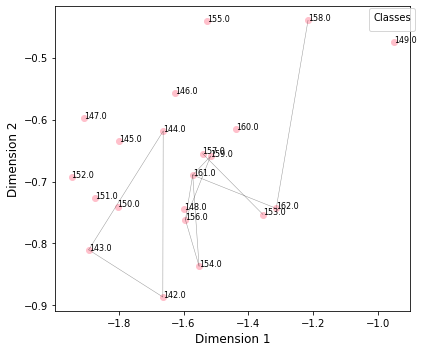

In [363]:
# Assuming class4Atsne DataFrame contains a "NodeNumber" column
class4Atsne = A_tsne_df[A_tsne_df["tau"] == 6]
# Make the index of class4Atsne a column called NodeNumber
class4Atsne = class4Atsne.reset_index()
class4Atsne.rename(columns={'index': 'NodeNumber'}, inplace=True)
# make NodeNumber column integer
class4Atsne["NodeNumber"] = class4Atsne["NodeNumber"].astype(int)

# Plot the scatter plot
fig, ax = plt.subplots(figsize=(6, 5))
scatter = ax.scatter(class4Atsne["Dimension_1"], class4Atsne["Dimension_2"], c='pink')
ax.set_xlabel("Dimension 1", fontsize=12)
ax.set_ylabel("Dimension 2", fontsize=12)

# Draw lines between connected nodes based on the adjacency matrix
# AND calculate the total Euclidean distance that the lines connecting the nodes in the tSNE plot cover
total_distance = 0
for i in range(len(class4Atsne)):
    for j in range(i + 1, len(class4Atsne)):
        if in_cov_friends_symm[i, j] == 1:  # Check if nodes i and j are connected
            ax.plot([class4Atsne["Dimension_1"].iloc[i], class4Atsne["Dimension_1"].iloc[j]], 
                    [class4Atsne["Dimension_2"].iloc[i], class4Atsne["Dimension_2"].iloc[j]], 
                    'k-', lw=0.5, alpha=0.4)  # Draw a line between them
            # Add this Euclidean distance to the total_distance
            total_distance += np.linalg.norm(class4Atsne[["Dimension_1", "Dimension_2"]].iloc[i] - class4Atsne[["Dimension_1", "Dimension_2"]].iloc[j])

total_distance = round(total_distance, 2)

# Add NodeNumber next to each point in the plot
for i, row in class4Atsne.iterrows():
    ax.text(row["Dimension_1"], row["Dimension_2"], str(row["NodeNumber"]), fontsize=8, color='black')

# Title
# ax.set_title(f"Perplexity: {perp_val}, B={B}. Mean 0, SD 1 \n Total Euclidean Distance of lines is {total_distance} \n {B} bootstraps used to estimate $U$, points are tSNE(A)")  

# Add legend for classes, mapping the integer labels back to the label_dict keys
handles, labels_legend = scatter.legend_elements()
label_dict_inv = {v: k for k, v in label_dict.items()}  
mapped_labels = []
for label in labels_legend:
    match = re.search(r'\d+', label)
    if match:
        numeric_label = int(match.group(0))
        mapped_labels.append(label_dict_inv[numeric_label])

fig.legend(handles, mapped_labels, title="Classes", loc="upper right", bbox_to_anchor=(0.98, 0.98), fontsize='medium', ncols=2)

# Adjust layout to make room for titles and labels
plt.tight_layout()

# Show the plot
plt.show()
